In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from statistics import mean 
import cv2
import pickle

In [2]:
# !!!!!!!!!!!!!!!!
#  if you already have saved dfs_splited_isnear_marks skip steps 0-4, make steps 5-8, skip steps 9-10, 
#  continue from the step 11
# !!!!!!!!!!!!!!!!

In [2]:
#0. open preprocessed trajectory data
#паузы исправлены
nam = 'preprocessed_dataset/preprocessed_dfs_subtraj_for_marks.pkl'
with open(nam, 'rb') as fp:
    dfs_dict = pickle.load(fp)

In [3]:
#откроем словарь 0.3 с чтобы были 0.3 с и сразу смерджим его
with open('preprocessed_dfs_subtraj_0.3s.pkl', 'rb') as fp:
    dfs_03 = pickle.load(fp)

# merge dfs of each mouse
#dict, where subtrajectories of 1 mice are merged in 1 df (with time jumps)
#the first row from each df is deleted because it has V=0
merg_dfs_03 = {}

for k, df in dfs_03.items():
    df = [df0.iloc[1:].reset_index() for df0 in df]
    merg_dfs_03[k] = pd.concat(df)
    merg_dfs_03[k] = merg_dfs_03[k].reset_index(drop=True)

<Figure size 640x480 with 0 Axes>

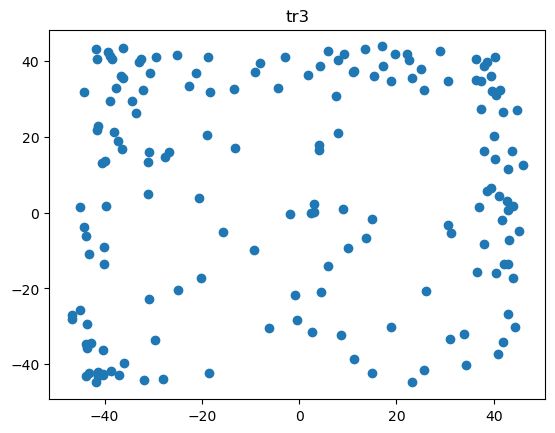

<Figure size 640x480 with 0 Axes>

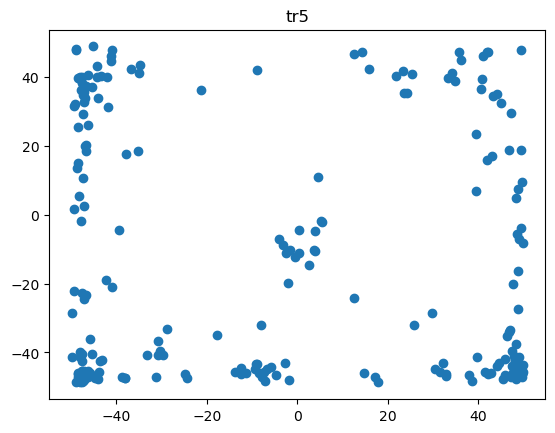

<Figure size 640x480 with 0 Axes>

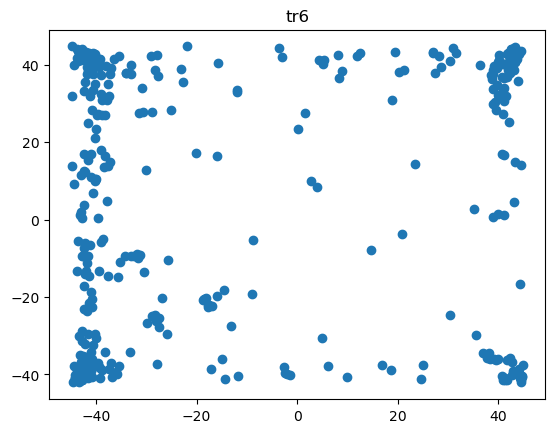

<Figure size 640x480 with 0 Axes>

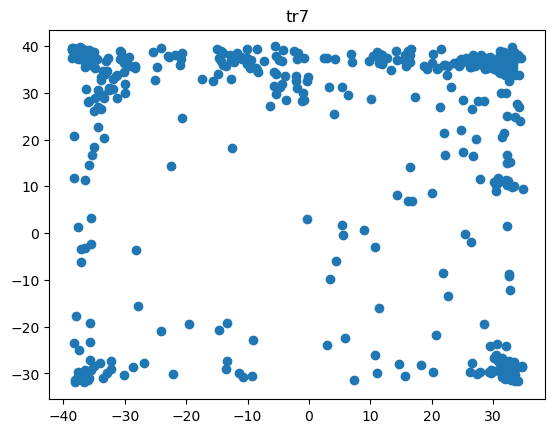

In [451]:
#графики остановок старого кода
# for i in range(len(names)):
#     plt.figure()
#     plotPauses(dfs[i])
#     plt.title(names[i])

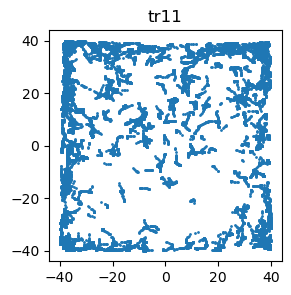

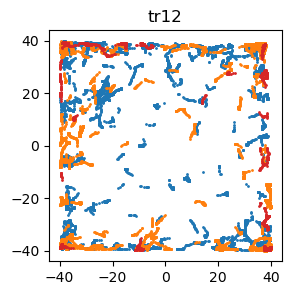

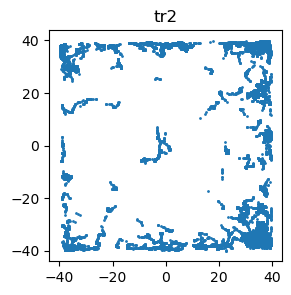

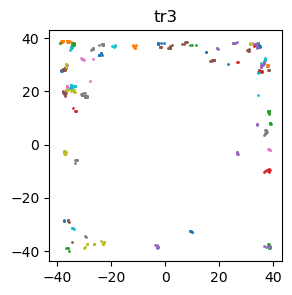

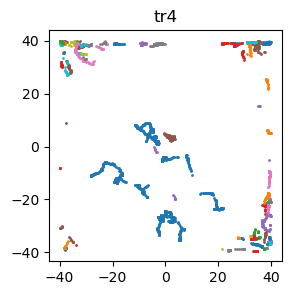

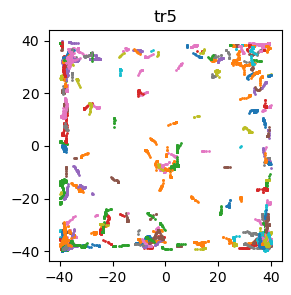

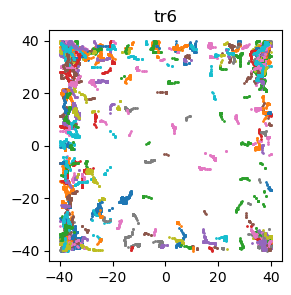

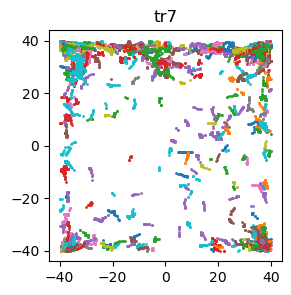

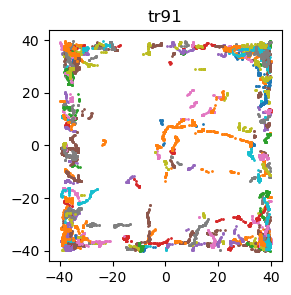

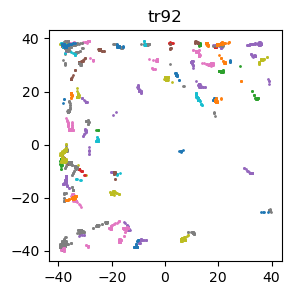

In [4]:
# (optional) 1. нарисуем точки, в которых мышь останавливалась
for k, df in dfs_dict.items():
    plt.figure(figsize=(3, 3))
    plt.title(k)
    for ldf in df:
        n_ldf = ldf.loc[ldf['movement']=='Stop']
        plt.scatter(n_ldf['x'], n_ldf['y'], s=1)
    plt.show()

In [5]:
#2. добавим в словарь фильтрованную скорость
def add_filtered_V(df, smooth_kern=2):
    dt = df['time'].diff()
    vx = df['x'].diff() / dt
    vy = df['y'].diff() / dt
    v = (vx**2 + vy**2)**0.5

    dt[0], vx[0], vy[0] = 0., 0., 0.
    v[0] = 0.
    df['Vx'] = gaussian_filter1d(vx, smooth_kern)  # TODO: why smoothing?
    df['Vy'] = gaussian_filter1d(vy, smooth_kern)
    df['V'] = gaussian_filter1d(v, smooth_kern)

    df.loc[0, 'Vx'] = 0.
    df.loc[0, 'Vy'] = 0.
    df.loc[0, 'V'] = 0.
    return df

for k, df in dfs_dict.items():
    sub_list = []
    i = 0
    for ldf in df:
        ldf = ldf.reset_index(drop=True)
        ldf = add_filtered_V(ldf)
        sub_list.append(ldf)
    dfs_dict[k] = sub_list

In [6]:
#3. merge dfs of 1 mouse

# merge dfs of each mouse
#dict, where subtrajectories of 1 mice are merged in 1 df (with time jumps)
#the first row from each df is deleted because it has V=0
merg_dfs_dict = {}

for k, df in dfs_dict.items():
    df = [df0.iloc[1:].reset_index() for df0 in df]
    merg_dfs_dict[k] = pd.concat(df)
    merg_dfs_dict[k] = merg_dfs_dict[k].reset_index(drop=True)

In [7]:
##4. split the table by time
start_end = {
'tr3': [1.268, 1567.099],
'tr5': [1.068, 1754.786],
'tr6': [1.068, 1662.261],
'tr7': [1.068, 1635.601],
'tr91': [1.068, 1463],
'tr92': [1.068, 645] }
#некоторые мыши (91, 92) под конец записи сидят на 1 месте
#может лучше в словарь запихнуть только используемых мышей

used_mice = ['tr3','tr5','tr6','tr7','tr91']

def cut_df(df_to_cut, n_of_parts, t1, t2):
    dur_of_part = (t2 - t1) / n_of_parts
    parts = []
    for i in range(n_of_parts):
        t1_local = t1 + dur_of_part * i
        t2_local = t1 + dur_of_part * (i+1)
        part_df = df_to_cut.loc[(df_to_cut['time'] > t1_local) & (df_to_cut['time'] < t2_local)]
        parts.append(part_df)
    return parts

In [8]:
n_to_split = 3
splited_dfs = {}
for m in used_mice:
    splited_dfs[m] = cut_df(merg_dfs_dict[m], n_to_split,
                            start_end[m][0], start_end[m][1])

### строим метки

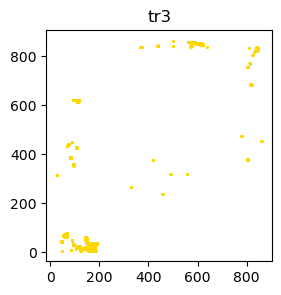

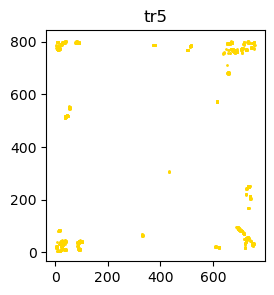

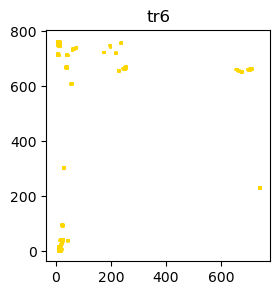

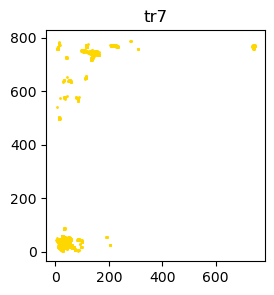

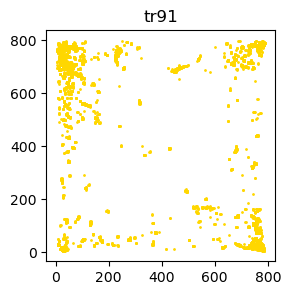

In [9]:
#5 из считанной картинки с метками делаем таблицу с координатами помеченных пикселей
#теперь метки сразу расположены правильно, как и траектории
def RedDFFromIm(im, k=''):
    coords = []
    #так, я поменяла местами х и у и соответсвенно хмакс умакс
    #вернула как было
    xmax = im.shape[0]
    ymax = im.shape[1]
    for i in range(len(im)):
        for j in range(len(im[i])):
            if (int(im[i][j][2]) - int(im[i][j][0]) > 15) and (int(im[i][j][2]) - int(im[i][j][0]) > 15):
                coords.append([i,j,im[i][j][2],im[i][j][1],im[i][j][0]])
    df = pd.DataFrame(coords, columns =['y', 'x', 'red', 'green', 'blue'])
    fig, ax = plt.subplots(figsize=(3, 3))
    #ax.set_xlim(xmax)
    #ax.set_ylim(ymax)
    ax.set_aspect('equal', adjustable='box')
    plt.title(k)
    plt.plot(df['x'], df['y'],'o', markersize=1, color='gold')
    plt.show()
    marks = {'df':df, 'xmax':xmax, 'ymax':ymax}
    return(marks)

IMG_DIR = 'marks_orig_pictures'
marks = {}
used_mice = ['tr3','tr5','tr6','tr7','tr91']  # 'tr92'
img_names = ['mark_3', 'mark_5', 'mark_6', 'mark_7', 'mark_9.1',]  # 'mark_9.2'

for tr_nam, img_nam in zip(used_mice, img_names):
    im = cv2.imread(f"{IMG_DIR}/{img_nam}.png")
    marks[tr_nam] = RedDFFromIm(im, tr_nam)

In [10]:
from utils.processing import rescale_coord

# 6. переводим метки и траектории в 1 координаты
rescaled_marks = {}
AREA_SIZE = [-40, 40]
for k, df in marks.items():
    rescaled_x = rescale_coord(df['df']['x'].to_numpy(),
                               AREA_SIZE[0], AREA_SIZE[1])
    rescaled_y = rescale_coord(df['df']['y'].to_numpy(),
                               AREA_SIZE[0], AREA_SIZE[1])
    df_ = pd.DataFrame({'x': rescaled_x, 'y': rescaled_y})
    rescaled_marks[k] = df_

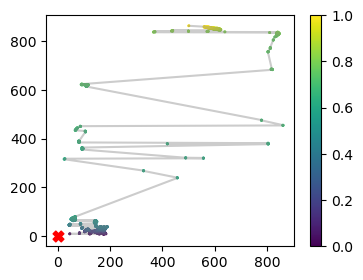

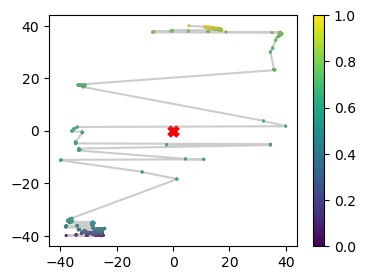

In [11]:
from utils.plotting import plot_trajectory

plt.figure(figsize=(4, 3))
plt.title('Before scaling')
plot_trajectory(marks['tr3']['df']['x'],
                marks['tr3']['df']['y'])

plt.figure(figsize=(4, 3))
plt.title('After scaling')
plot_trajectory(rescaled_marks['tr3']['x'],
                rescaled_marks['tr3']['y'])

Text(0.5, 1.0, 'tr3')

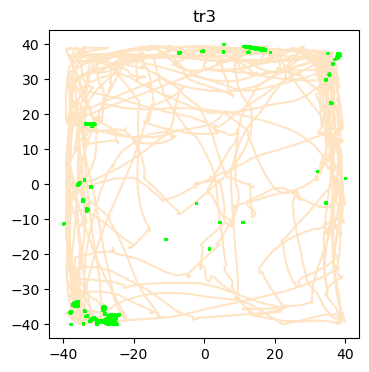

In [12]:
#вроде так верно
plt.figure(figsize=(4, 4))
plt.scatter(rescaled_marks['tr3']['x'], rescaled_marks['tr3']['y'],
            c='lime', s=1.5, zorder=1)
plt.plot(merg_dfs_dict['tr3']['x'], merg_dfs_dict['tr3']['y'],
         c='bisque', zorder=0)
plt.title('tr3')

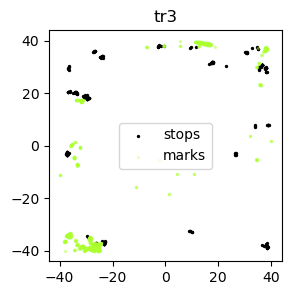

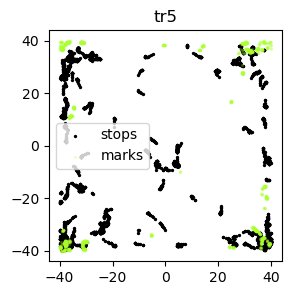

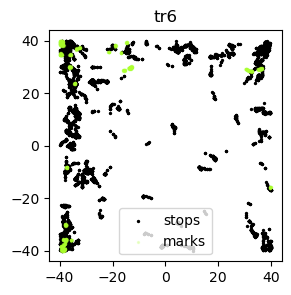

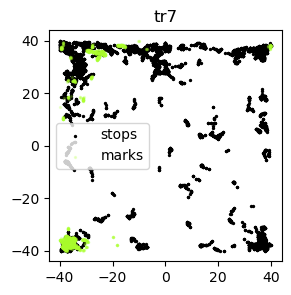

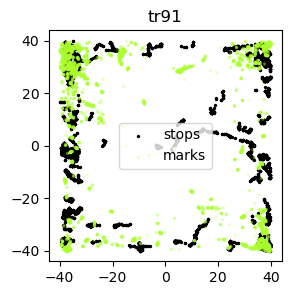

In [13]:
#метки и остановки  # TODO: correct rotation?
for k, df_n in splited_dfs.items():
    df = df_n[2]  # take the last 1/3 part
    df_stop = df.loc[df['movement']=='Stop']
    plt.figure(figsize=(3, 3))
    plt.scatter(df_stop['x'], df_stop['y'], c='k', s=2,
                label='stops')
    plt.scatter(rescaled_marks[k]['x'],
                rescaled_marks[k]['y'],
                c='greenyellow', alpha=0.2, s=2,
                label='marks')
    plt.title(k)
    plt.legend()
    plt.show()

In [14]:
def df_minmax(occ):
    if isinstance(occ, pd.DataFrame):
        occ = occ.to_numpy()
    kk = (occ - np.amin(occ)) / (np.amax(occ) - np.amin(occ))
    kl = pd.DataFrame(kk)
    return kl

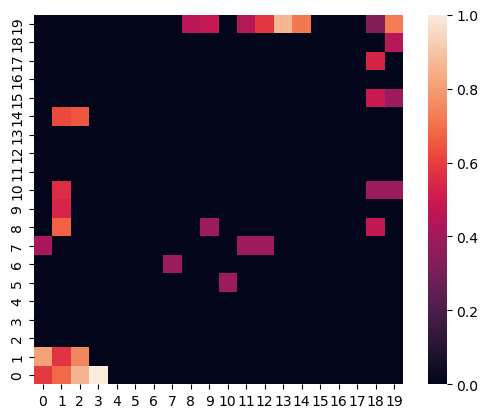

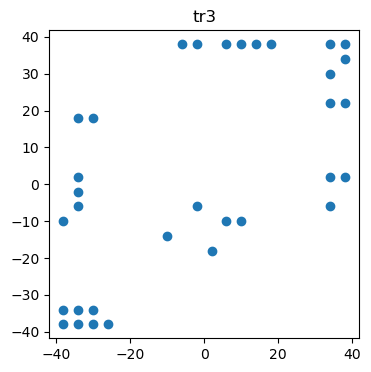

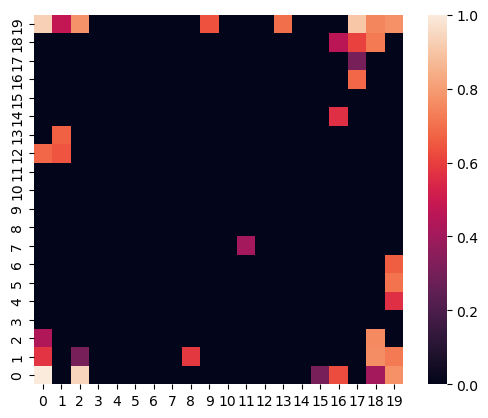

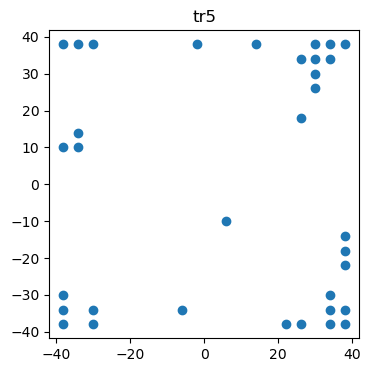

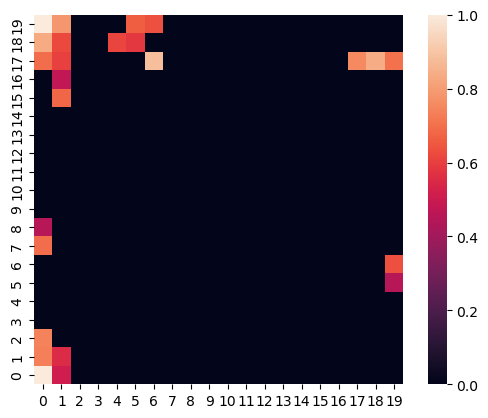

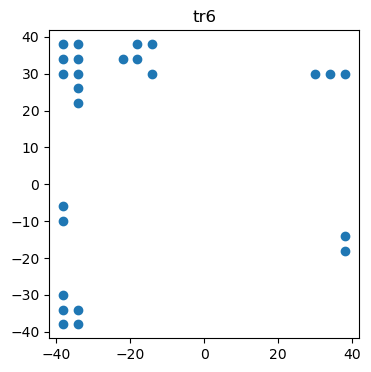

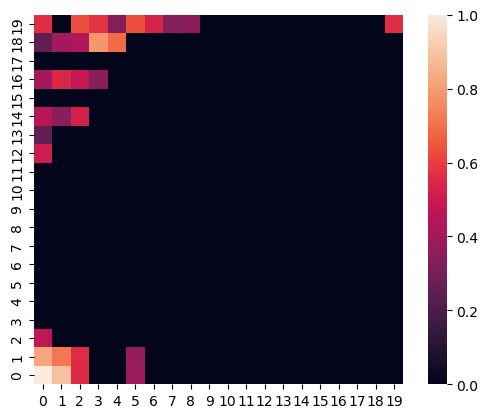

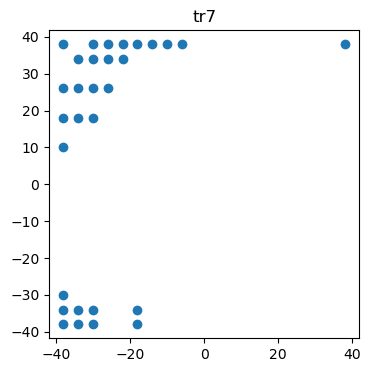

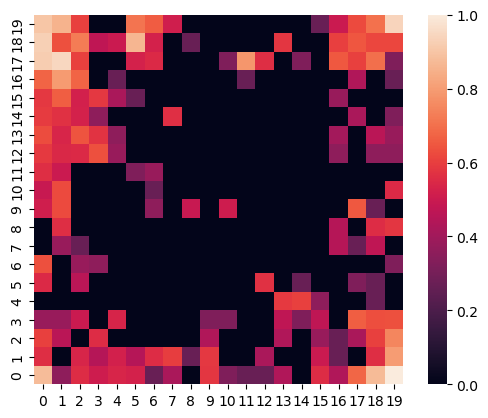

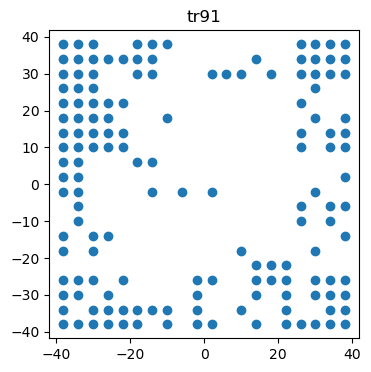

In [57]:
#7 функция окууп карта меток dfHM
#parameter to change!!!!! n
# тут, может есть лишние вращения, но изначально (до этого шага) и в результате этого шага все расположено правильно, 
# в единой системе координат
#поч немного поменялось расположение меток, наверное, были смещены границы/бины

METKA_THRESH = 0.3

def make_occup_map(df, n=20, eps=1e-3, scaling='sqrt'):
    """
    на вход нужна таблица с time x y 
    """
    binx = np.linspace(AREA_SIZE[0]-eps, AREA_SIZE[1]+eps, n+1)
    x_cut = pd.cut(df['x'], binx, right=False)
    biny = np.linspace(AREA_SIZE[0]-eps, AREA_SIZE[1]+eps, n+1)
    y_cut = pd.cut(df['y'], biny, right=False)
    
    dfn = df.groupby([x_cut, y_cut], observed=False).count()
    dfn = dfn.drop(columns=['x', 'y'])

    L = [(a.mid, b.mid) for a, b in dfn.index]
    dfm = dfn.set_index(pd.MultiIndex.from_tuples(L, names=dfn.index.names))

    dd = dfm.unstack()
    arrd = dd.replace(0, 1e-2).to_numpy()
    if scaling=='sqrt':
        arrsrsr = np.sqrt(np.sqrt(np.sqrt(arrd)))
    elif scaling=='log':
         arrsrsr = np.log(arrd)
    kk = df_minmax(arrsrsr)

    kk = kk.transpose()
    kk = kk.iloc[::-1]  # rotate occupancy map
    #new_ind = kk.columns 
    #kk.columns = kk.index
    #kk.index = new_ind
    sns.heatmap(kk, square=True)
    return kk, binx, biny

#8 делаем координаты новых "меток" - центров квадратов, в которых достаточно много меток

def heat_maps_with_coords(marksN, tit='', show=True):
    
    # 1. build occupation (heat) map of marks
    dfHM, binx, biny = make_occup_map(marksN, n=20) 
    
    # 2. occ map in which indices are coordinates
    binxmid, binymid = [], []
    for i in range(1, len(binx)):
        binxmid.append((binx[i] + binx[i-1]) / 2)
        binymid.append((biny[i] + biny[i-1]) / 2)
    dfHM.index = binxmid[::-1]
    dfHM.columns = binymid

    # 3. take coordinates of cells with sufficient amount of urine marks 
    # вытащим координаты квадратов где довольно много меток
    # координаты меток т.е. i это y (row) а j это x (column)
    # parameter to change 0.3
    trN_coords = []
    for i in range(dfHM.shape[0]-1, -1, -1):
        for j in range(dfHM.shape[1]):
            if dfHM.iloc[i, j] > METKA_THRESH:
                trN_coords.append((dfHM.columns[j], dfHM.index[i]))
    if show:
        plt.figure(figsize=(4, 4))
        trN_coords_x = [i[0] for i in trN_coords]
        trN_coords_y = [i[1] for i in trN_coords]
        plt.scatter(trN_coords_x, trN_coords_y)
        plt.title(tit)
        plt.show()
    return trN_coords

hm_marks_coords = {}
for n in used_mice:
    df = rescaled_marks[n]
    df['c'] = np.ones((rescaled_marks[n].shape[0])) # instead of time
    hm_marks_coords[n] = heat_maps_with_coords(df, tit=n)
    # break

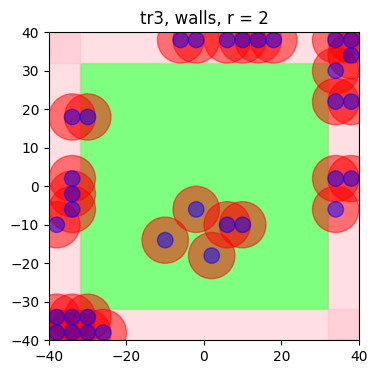

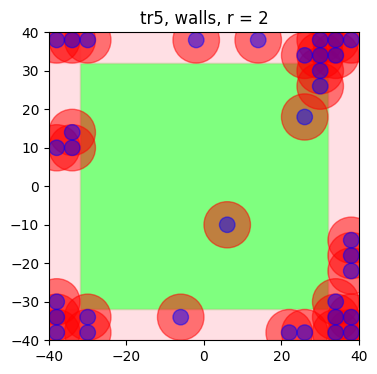

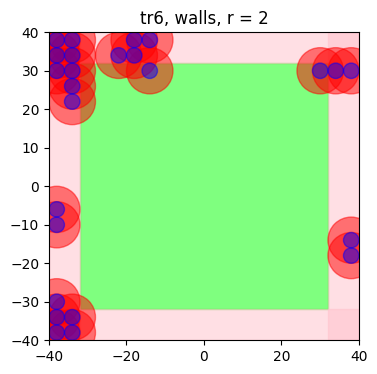

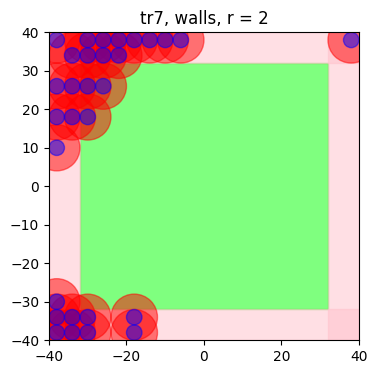

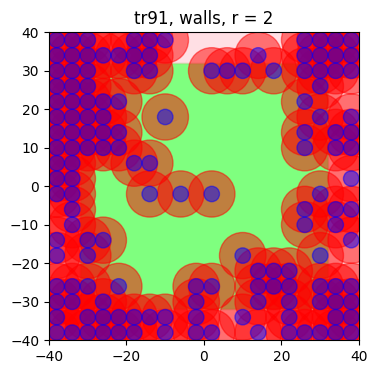

In [133]:
#9. (additional) make pictures to compare areas of marks surroundings vs regular space
r1 = 2
r2 = 3 * r1

for n in used_mice:
    fig, ax = plt.subplots(figsize=(4, 4))
    square = Rectangle((-32, -32), 64, 64, color=(0, 1, 0),
                           alpha=0.5)
    ax.add_patch(square)

    squares = [Rectangle((-40, -40), 8, 80),
                Rectangle((32, -40), 8, 80),
                Rectangle((-40, -40), 80, 8),
                Rectangle((-40, 32), 80, 8)]
    sq = PatchCollection(squares, alpha=0.5, color='pink')
    ax.add_collection(sq)

    # TODO: add corners
    
    for r, col in zip([r2, r1], ['red', 'blue']):
        patches = []
        coords = hm_marks_coords[n]
        for c in coords:
            circle = Circle((c[0], c[1]), r)
            patches.append(circle)
        p = PatchCollection(patches, color=col, alpha=0.5)
        ax.add_collection(p)

    plt.xlim(-40, 40)
    plt.ylim(-40, 40)
    name = n + ', walls' + ', r = ' + str(r)
    plt.title(name)
    plt.show()
    # break

In [225]:
#10. размечаем в таблице траектории какие точки находятся в окрестностях r1 и r2 меток, а какие нет

def calc_marks_masks(trN, trN_marks_coords, r1=2, r2=6):
    trN_marks_coords = np.asarray(trN_marks_coords)
    x_metki = trN_marks_coords[:, 0][..., np.newaxis]
    y_metki = trN_marks_coords[:, 1][..., np.newaxis]

    xm = np.tile(trN['x'].values, (x_metki.shape[0], 1))
    ym = np.tile(trN['y'].values, (y_metki.shape[0], 1))

    # shape: [num_metki, num_points]
    dist = ((xm - x_metki)**2 + (ym - y_metki)**2)**0.5  
    mask_r1 = dist <= r1
    mask_r2 = dist <= r2

    # plt.figure(figsize=(14, 10))  # TODO: you can look at the timeline
    # plt.imshow(mask_r1*1)
    # plt.show()
    # plt.figure(figsize=(14, 10))
    # plt.imshow(mask_r2*1)
    # plt.show()

    return mask_r1, mask_r2

def add_marks_intersect_times(df, m_r1, m_r2):
    """ 
    adds to df 2 columns: 'r1' and 'r2'
    calculate if a time point in ANY mark
    sum up all intersected marks, so add duplicate in marks clusters
    """
    counts_r1 = np.sum(m_r1*1, axis=0)
    counts_r2 = np.sum(m_r2*1, axis=0)
    # print(np.unique(counts_r1, return_counts=True)) # TODO: u can look at uniqe vals
    # print(np.unique(counts_r2, return_counts=True))
    df_ = df.copy()
    df_['r1'] = counts_r1
    df_['r2'] = counts_r2
    return df


dfs_splited_isnear_marks = {}
for m in used_mice:
    subtraj_list = []
    for df in splited_dfs[m]:
        m_r1, m_r2 = calc_marks_masks(df, hm_marks_coords[m], r1=2, r2=6)
        subtraj_list.append(add_marks_intersect_times(df, m_r1, m_r2))
        dfs_splited_isnear_marks[m] = subtraj_list
        # break
    # break

In [ ]:
# TODO: create super clusters from metki, 
#       from occup map calc a coeff of strengh of this this super cluster
# TODO: просто коэффициент сколько меток по сравнению с общей площадью (в бинах). 
#       N metki bins / N all bins - for each mouse 
# TODO: distribure metki in 3 types of areas (corners, walls, center)
# TODO: we can do split at the end of analysis, not before :)
# TODO: как статистически доказать что мышь возле стен и мышь возле меток+стен различаются?
#       какие данные брать?
#       1. cравнивать у мышей tr3, tr6, tr7 стены с метками и без (все сэмплы) 
#       по скорости, occupancy, остановкам, частоту пересечения 
#       (the first passage time ??)

# ANALYSIS:
# TODO: is there some correlation between parameters of mouse and strengh of metkas?
# TODO: is there some difference between parameters of mouse and 3 types of metkas?
# TODO: plot vector field + metki, occup map + metki
# TODO: frequency of visiting metki (compare with any point in the same area type, e.g. wall)
# TODO: tr3, tr6, tr7 - есть углы без меток?

# TODO: all the same but for 3 time parts of mouse in the field
# TODO: can we see difference in 1st and 3rd part of recording?

In [230]:
# Save distributions
with open('preprocessed_dataset/splited_isnear_marks.pkl', 'wb') as fp:    
    pickle.dump(dfs_splited_isnear_marks, fp)

In [14]:
#11. open dfs_splited_isnear_marks if we skipped steps 0-4, 9-10
with open('preprocessed_dataset/splited_isnear_marks.pkl', 'rb') as fp:
    dfs_splited_isnear_marks = pickle.load(fp)

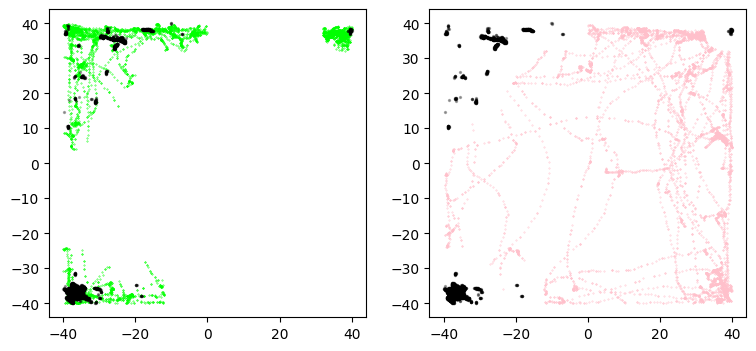

In [240]:
#check surrounding of marks
df = dfs_splited_isnear_marks['tr7'][0]

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
check = df.loc[(df['r2']>0) & (df['r1']>=0)]
ax[0].scatter(check['x'], check['y'], s=0.1, c='lime')
ax[0].scatter(rescaled_marks['tr7']['y'],
              rescaled_marks['tr7']['x'], s=2, c='black', alpha=0.3)

check1 = df.loc[(df['r2']==0) & (df['r1']==0)]
ax[1].scatter(check1['x'], check1['y'], s=0.1, c='pink')
ax[1].scatter(rescaled_marks['tr7']['y'],
              rescaled_marks['tr7']['x'],s=2, c='black', alpha=0.3)
plt.show()

In [23]:
# 12. compare navigation parameters between marks surroundings and the remaining area

In [ ]:
# STOPPED HERE
# ==================================
# ==================================
# ==================================
# ==================================

In [38]:
#make df with percent of samples, percent of pauses, velocities in marks surroundings and the remaining area

#walls

navig_pars_walls = pd.DataFrame()

for n, trs in dfs_splited_isnear_marks.items():
    for i in range(len(trs)):
        tr = trs[i]
        m1 = len(tr.loc[(tr['r1']>0) & (tr['near_wall']>0)]) / len(tr)
        m2 = len(tr.loc[(tr['r1']==0) & (tr['r2'] > 0) & (tr['near_wall']>0)]) / len(tr)
        m3 = len(tr.loc[(tr['r1']==0) & (tr['r2'] == 0) & (tr['near_wall']>0)]) / len(tr)
        
        tr_p = tr.loc[tr['movement']=='Stop']
        p1 = len(tr_p.loc[(tr_p['r1']>0) & (tr_p['near_wall']>0)]) / len(tr_p)
        p2 = len(tr_p.loc[(tr_p['r1']==0) & (tr_p['r2'] > 0) & (tr_p['near_wall']>0)]) / len(tr_p)
        p3 = len(tr_p.loc[(tr_p['r1']==0) & (tr_p['r2'] == 0) & (tr_p['near_wall']>0)]) / len(tr_p)
        
        v1 = tr.loc[(tr['r1']>0) & (tr['near_wall']>0)]['V'].mean()
        v2 = tr.loc[(tr['r1']==0) & (tr['r2'] > 0) & (tr['near_wall']>0)]['V'].mean()
        v3 = tr.loc[(tr['r1']==0) & (tr['r2'] == 0) & (tr['near_wall']>0)]['V'].mean()
        
        vv1 = tr.loc[(tr['r1']>0) & (tr['near_wall']>0)]['V'].to_numpy()
        vv2 = tr.loc[(tr['r1']==0) & (tr['r2'] > 0) & (tr['near_wall']>0)]['V'].to_numpy()
        vv3 = tr.loc[(tr['r1']==0) & (tr['r2'] == 0) & (tr['near_wall']>0)]['V'].to_numpy()

        lildf_np = pd.DataFrame({'mouse':[n, n, n], 'time_part':[i+1, i+1, i+1], 'near_mark':['r1','r2','0'], 
                                 'near_wall/near_wall':['near_wall','near_wall','near_wall'], 
                                 'percent_of_samp':[m1,m2,m3],
                                 'pers_of_pause': [p1, p2, p3],
                                 'mean_v':[v1,v2,v3],'all_v':[vv1, vv2, vv3]})
        navig_pars_walls = navig_pars_walls.append(lildf_np)
            
navig_pars_walls = navig_pars_walls.reset_index(drop=True)


#чтобы посчитать нормально разницу между разными зонами я переношу их в excel и делю на площадь


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3744\4195885421.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  navig_pars_walls = navig_pars_walls.append(lildf_np)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3744\4195885421.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  navig_pars_walls = navig_pars_walls.append(lildf_np)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3744\4195885421.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  navig_pars_walls = navig_pars_walls.append(lildf_np)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3744\4195885421.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  navig_pars_walls = navig_pars

In [36]:
#center

navig_pars_center = pd.DataFrame()

for n, trs in dfs_splited_isnear_marks.items():
    for i in range(len(trs)):
        tr = trs[i]

        m1 = len(tr.loc[(tr['r1']>0) & (tr['near_wall']==0)]) / len(tr)
        m2 = len(tr.loc[(tr['r1']==0) & (tr['r2'] > 0) & (tr['near_wall']==0)]) / len(tr)
        m3 = len(tr.loc[(tr['r1']==0) & (tr['r2'] == 0) & (tr['near_wall']==0)]) / len(tr)
        
        tr_p = tr.loc[tr['movement']=='Stop']
        p1 = len(tr_p.loc[(tr_p['r1']>0) & (tr_p['near_wall']==0)]) / len(tr_p)
        p2 = len(tr_p.loc[(tr_p['r1']==0) & (tr_p['r2'] > 0) & (tr_p['near_wall']==0)]) / len(tr_p)
        p3 = len(tr_p.loc[(tr_p['r1']==0) & (tr_p['r2'] == 0) & (tr_p['near_wall']==0)]) / len(tr_p)
        
        v1 = tr.loc[(tr['r1']>0) & (tr['near_wall']==0)]['V'].mean()
        v2 = tr.loc[(tr['r1']==0) & (tr['r2'] > 0) & (tr['near_wall']==0)]['V'].mean()
        v3 = tr.loc[(tr['r1']==0) & (tr['r2'] == 0) & (tr['near_wall']==0)]['V'].mean()
        
        vv1 = tr.loc[(tr['r1']>0) & (tr['near_wall']==0)]['V'].to_numpy()
        vv2 = tr.loc[(tr['r1']==0) & (tr['r2'] > 0) & (tr['near_wall']==0)]['V'].to_numpy()
        vv3 = tr.loc[(tr['r1']==0) & (tr['r2'] == 0) & (tr['near_wall']==0)]['V'].to_numpy()

        lildf_np = pd.DataFrame({'mouse':[n, n, n], 'time_part':[i+1, i+1, i+1], 'near_mark':['r1','r2','0'], 
                                'near_wall/center':['center','center','center'], 
                                 'percent_of_samp':[m1,m2,m3],
                                 'pers_of_pause': [p1, p2, p3],
                                'mean_v':[v1,v2,v3],'all_v':[vv1, vv2, vv3]})
        navig_pars_center = navig_pars_center.append(lildf_np)
            
navig_pars_center = navig_pars_center.reset_index(drop=True)


#чтобы посчитать нормально разницу между разными зонами я переношу их в excel и делю на площадь


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3744\401847708.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  navig_pars_center = navig_pars_center.append(lildf_np)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3744\401847708.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  navig_pars_center = navig_pars_center.append(lildf_np)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3744\401847708.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  navig_pars_center = navig_pars_center.append(lildf_np)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3744\401847708.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  navig_pars_center = navig_p

In [40]:
#mean velocities near wall

df = navig_pars_wall.loc[navig_pars_wall['time_part']==1]
print('time part 1, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')
# print('r1, r2', ttest_ind(v_r1, v_r2))
# print('0, r1', ttest_ind(v_0, v_r1))
# print('0, r2', ttest_ind(v_0, v_r2))

df = navig_pars_wall.loc[navig_pars_wall['time_part']==2]
print('time part 2, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')

df = navig_pars_wall.loc[navig_pars_wall['time_part']==3]
print('time part 3, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')

time part 1, near_wall
v_r1 7.0854442416070835
v_r2 9.364252216598741
v_0 12.499077031489186

time part 2, near_wall
v_r1 7.132542340849563
v_r2 10.4476420233558
v_0 13.599534338089375

time part 3, near_wall
v_r1 6.228164619252433
v_r2 9.073948845529456
v_0 11.08537174289897



In [41]:
#mean velocities center

df = navig_pars_center.loc[navig_pars_center['time_part']==1]
print('time part 1, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')
# print('r1, r2', ttest_ind(v_r1, v_r2))
# print('0, r1', ttest_ind(v_0, v_r1))
# print('0, r2', ttest_ind(v_0, v_r2))

df = navig_pars_center.loc[navig_pars_center['time_part']==2]
print('time part 2, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')

df = navig_pars_center.loc[navig_pars_center['time_part']==3]
print('time part 3, near_wall')
v_r1 = df.loc[df['near_mark']=='r1']['mean_v']
v_r2 = df.loc[df['near_mark']=='r2']['mean_v']
v_0 = df.loc[df['near_mark']=='0']['mean_v']
print('v_r1', ' ', mean(v_r1), '\n','v_r2', ' ', mean(v_r2), '\n', 'v_0', ' ', mean(v_0), '\n',sep='')

time part 1, near_wall
v_r1 nan
v_r2 20.40554557257709
v_0 17.36593508490693

time part 2, near_wall
v_r1 18.32294966845268
v_r2 15.12654644513732
v_0 16.361547392623944

time part 3, near_wall
v_r1 17.01864399318324
v_r2 13.22710576952831
v_0 14.280211437237961



In [43]:
navig_pars_wall.to_excel('navig_pars_wall.xlsx')
navig_pars_center.to_excel('navig_pars_center.xlsx')

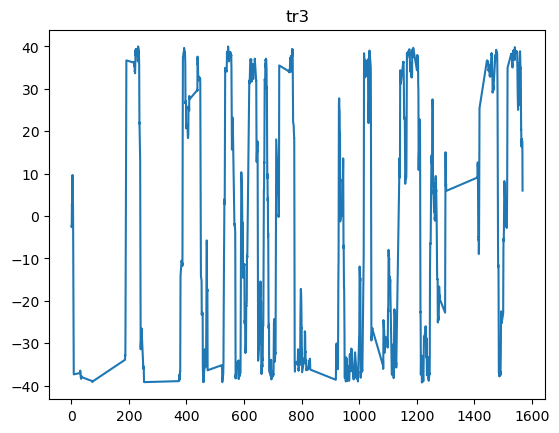

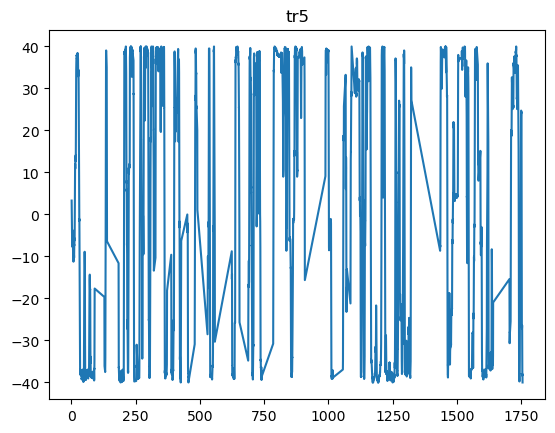

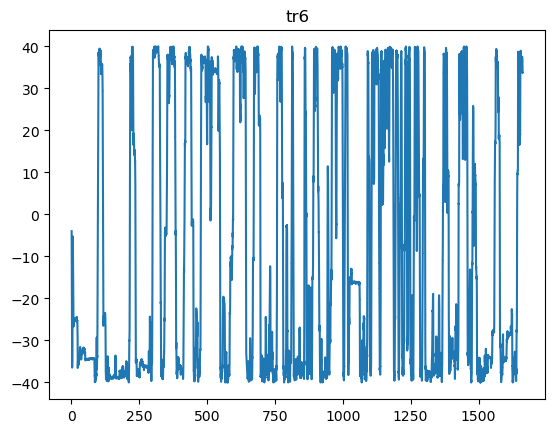

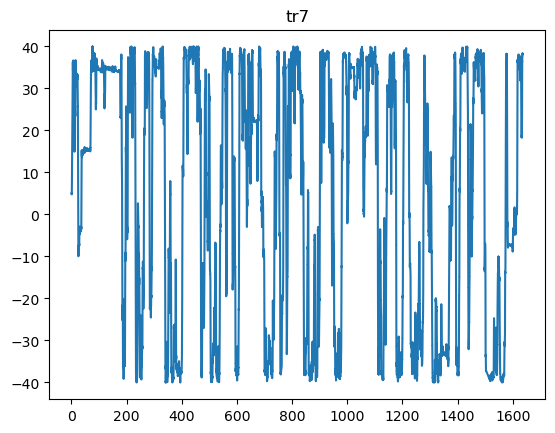

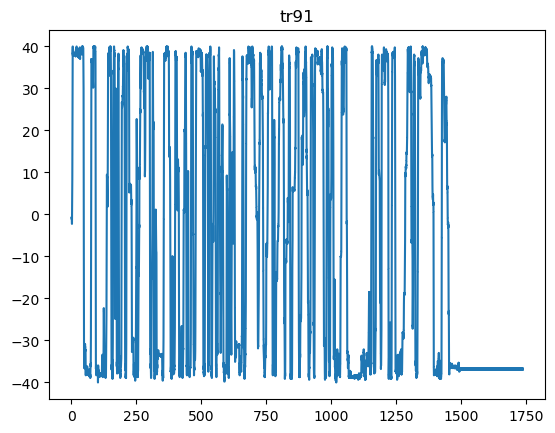

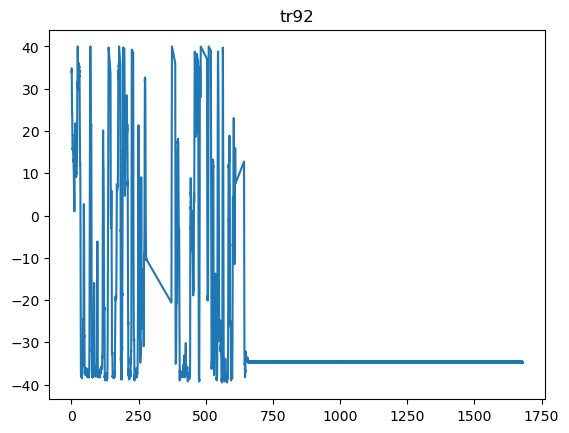

In [20]:
for i in ['tr3','tr5','tr6','tr7', 'tr91', 'tr92']:
    plt.plot(merg_dfs_dict[i]['time'],merg_dfs_dict[i]['x'])
    plt.title(i)
    plt.show()

In [113]:
#на вход нужна таблица с time x y 
# _1_ окууп карта меток dfHM
#блин бин х это y с тз траджа... ну аутпут беру верный. Хотя щас уже наоборот...

#parameter to change!!!!! n

def make_occup_map(marks_i, xmi=-40, xma=40, ymi=-40, yma=40, n=20):
    df = marks_i['df']
    binx = np.linspace(xmi, xma, n+1)
    #x_cut = pd.cut(df.X, binx, right=False)
    x_cut = pd.cut(df['x'], binx, right=False)

    biny = np.linspace(ymi, yma, n+1)
    #y_cut = pd.cut(df.Y, biny, right=False)
    y_cut = pd.cut(df['y'], biny, right=False)

    dfn = df.groupby([x_cut, y_cut]).count()
    
    L = [(a.mid, b.mid) for a, b in dfn.index]
    dfm = dfn.set_index(pd.MultiIndex.from_tuples(L, names=dfn.index.names))
    dfm = dfm.drop(columns=['x','y', 'green', 'blue'])
    dd = dfm.unstack()
    dd = dd.replace(0, 1.e-1)
    arrd = dd.to_numpy()
    arrsrsr = np.sqrt(np.sqrt(np.sqrt(arrd)))
    kk = (arrsrsr - np.amin(arrsrsr)) / (np.amax(arrsrsr) - np.amin(arrsrsr))
    kk = pd.DataFrame(kk)
    kk = kk.iloc[::-1]
    #kk = kk.iloc[:, ::-1]
    sns.heatmap(kk, square=True)
    #sns.heatmap(kk, square=True, xticklabels=False, yticklabels=False)
    return(kk, binx, biny)


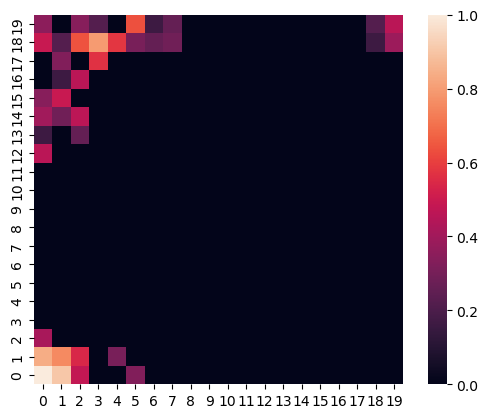

In [114]:
dfHM, biny, binx = make_occup_map(marks['tr7'])

In [115]:
# _2_ оккуп карта с индексами-координатами

binxmid = []
for i in range(len(binx)):
    if i != 0:
        binxmid.append((binx[i]+binx[i-1])/2)

binymid = []
for i in range(len(biny)):
    if i != 0:
        binymid.append((biny[i]+biny[i-1])/2)

dfHM.index = binxmid[::-1]
dfHM.columns = binymid

dfHM
        

,-38.0,-34.0,-30.0,-26.0,-22.0,-18.0,-14.0,-10.0,-6.0,-2.0,2.0,6.0,10.0,14.0,18.0,22.0,26.0,30.0,34.0,38.0
38.0,0.355072,0.000000,0.341136,0.221123,0.000000,0.634099,0.162367,0.257929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.221123,0.457239
34.0,0.488714,0.221123,0.639334,0.794292,0.579544,0.307035,0.257929,0.285198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.162367,0.389261
30.0,0.000000,0.325335,0.000000,0.566417,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
26.0,0.000000,0.162367,0.457239,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
22.0,0.341136,0.493327,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
18.0,0.398842,0.285198,0.463015,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
14.0,0.162367,0.000000,0.257929,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
10.0,0.457239,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000


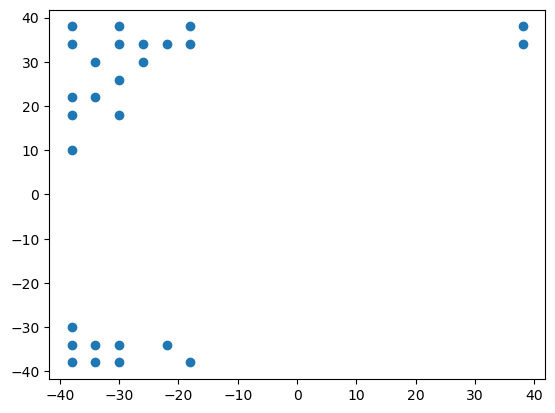

In [116]:
# _3_ вытащим координаты квадратов где довольно много меток
#координаты меток
#старое: т е i это y (row) а j это x (column)
#новое!! i это x (row) а j это y (column)
#parameter to change 0.3
tr7_coords = []
for i in range(dfHM.shape[0]-1, -1, -1):
    for j in range(dfHM.shape[1]):
        if dfHM.iloc[i, j] > 0.3:
            #print(dfHM.index[i], dfHM.columns[j])
            tr7_coords.append((dfHM.columns[j], dfHM.index[i]))
            



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_180\1764278431.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr7['r2'].iloc[i] += 1
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_180\1764278431.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tr7['r1'].iloc[i] += 1


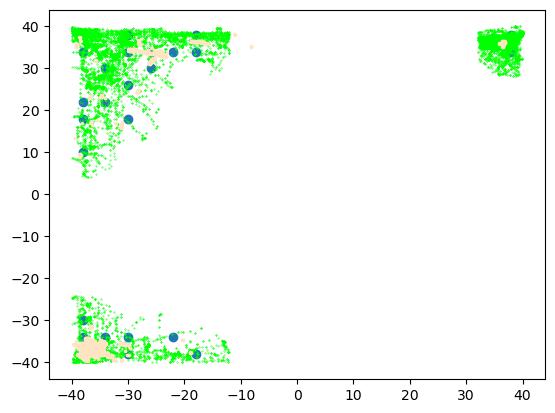

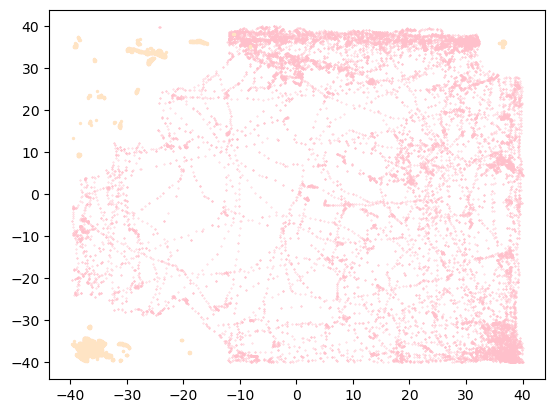

In [112]:
# _4_ для каждой точки определим, находится ли она в р1 р2 
r1 = 2
r2 = 3 * r1

tr7 = merg_dfs_dict['tr7']
tr7['r1'] = 0
tr7['r2'] = 0

for i in range(len(tr7)):
    for j in tr7_coords:
        if ((tr7['x'].iloc[i] - j[0]) ** 2) + ((tr7['y'].iloc[i] - j[1]) ** 2) < (r1 ** 2):
            tr7['r1'].iloc[i] += 1
        if ((tr7['x'].iloc[i] - j[0]) ** 2) + ((tr7['y'].iloc[i] - j[1]) ** 2) <= (r2 ** 2):
            tr7['r2'].iloc[i] += 1
            

check = tr7.loc[(tr7['r2']>0) & (tr7['r1']>=0)]
plt.scatter(check['x'], check['y'], s=0.1, c='lime')
plt.scatter(marks['tr7']['df']['y'],marks['tr7']['df']['x'],s=2, c='bisque')
plt.figure()
check1 = tr7.loc[(tr7['r2']==0) & (tr7['r1']==0)]
plt.scatter(check1['x'], check1['y'], s=0.1, c='pink')
plt.scatter(marks['tr7']['df']['y'],marks['tr7']['df']['x'],s=2, c='bisque')


In [ ]:
for i in ['tr91']:
    fig, ax = plt.subplots()
    plt.plot(merg_dfs_dict[i]['time'],merg_dfs_dict[i]['x'])
    plt.title(i)
    ax.set_xlim(1450, 1454)
    plt.show()